<center>
<img src="../../img/ods_stickers.jpg"></center>

## <center>Открытый курс по машинному обучению. Сессия № 3</center>

### <center>Индивидуальный проект по анализу данных</center>

## <center>Прогнозирование пристройства домашних животных</center>

<left><i>автор: Осипова Зоя</i></left>

##  Описание набора данных и признаков

### Общее описание проблемы

Проблема потерявшихся и бездомных животных стоит особенно остро в крупных городах. Актуальной задачей является поиск хозяев, социализация, и в случае не нахождения оных, пристройство животного в новые руки.
Наиболее близким переводом на русский, отражающим деятельность центра, думаю, будет термин "приют для животных", который осуществляет поиск новых или старых хозяев, а также привлечение добровольцев для временной передержки и помощи. Данной центр является самым большим в США приютом для животных, проводящий политику "no-kill" (животные не усыпляются по прошествии какого-то времени нахождения в приюте).

### Данные

Наборы данных взят непосредственно с сайта центра [Austin Animal Center](http://www.austintexas.gov/department/aac), 19 апреля 2018 года (датасет обновляется ежедневно и ведется с 2013 года).
Данные были доступны по ссылкам на сайте центра: [раз](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) и [два](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238), если не получается скачать (у меня несколько последних дней не открывались, возможно из-за РКН), то Яндекс-диск: [Outcomes](https://yadi.sk/i/USIwAMaR3UeosH) и [Intakes](https://yadi.sk/i/1J6Bher-3Ueoud)

### Признаки

Датасет содержит информацию о более чем 80 тысяч животных, присутствуют несколько категорий - собаки, кошки, птицы и остальные.
Есть данные о возрасте, имени (если есть), времени поступлении в приют, и так далее. Данные содержатся в двух таблицах, рассмотрим подробнее:

<b>Таблица outcomes:</b>
- <b>Animal ID (animal_id)</b> - идентификатор животного
- <b>Name (animal_id)</b> - имя животного
- <b>DateTime (outcome_time)</b> - дата "выпуска" из центра
- <b>MonthYear (outcome_monthyear)</b> - месяц-год выпуска
- <b>Date of Birth (date_of_birth)</b> - дата рождения
- <b>Animal Type (animal_type)</b> - вид животного (кошка, собака, птица и т.д.)
- <b>Sex upon Outcome (outcome_sex)</b> - пол на момент выпуска (может меняться, так как кроме женского/мужского присутствуют указания кастрированно/стерилизованно ли животное)
- <b>Age upon Outcome (outcome_age)</b> - возраст на момент выпуска
- <b>Breed (breed)</b> - порода
- <b>Color (color)</b> - цвет
- <b>Outcome Type (outcome_type)</b> - интересующая нас целевая переменная, принимает 9 значений: Adoption, Died, Euthanasia, Disposal, Missing, Rto-adopt, Relocate. Тут в основном все понятно, единственное, затрудняюсь сказать что такое Rto-adopt, возможно повторное возвращение к человеку, однажды забравшему животного.
- <b>Outcome Subtype (outcome_subtype)</b> - пояснения к Outcome Type, полупустой столбец


<b>Таблица intakes:</b>
Часть данных повторяется, помимо этого:
- <b>Intake Type (intake_type)</b> - как поступило животное (найдено в дикой природе, кто-то привез, и т.д.)
- <b>Intake Condition (intake_condition)</b> - в каком состоянии найдено животное
- <b>DateTime (intake_time)</b> - дата поступления
- <b>MonthYear (intake_monthyear)</b> - месяц-год поступления
- <b>Age upon Intake (intake_age)</b> - возраст на момент поступления
- <b>Found Location (found_location)</b> - где найдено
- <b>Sex upon Intake (intake_sex)</b> - пол на момент поступления

### Цели и задачи

Задачей данного проекта является поиск закономерностей и прогнозирование судьбы животных, попавших в приют. Понимание того, от каких признаков зависит пристройство животного, во-первых, могло бы позволить центру лучше прогнозировать ресурсы, во-вторых, возможно, проводить какие-то социальные кампании.

## Первичный анализ признаков

### Импорт библиотек

In [37]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, validation_curve, learning_curve
from sklearn.ensemble import RandomForestClassifier

sns.set_style('whitegrid')

### Загружаем данные из таблицы Outcomes

In [2]:
outcomes = pd.read_csv('Austin_Animal_Center_Outcomes.csv', sep=',', index_col=False)

In [3]:
outcomes.columns

Index(['Animal ID', 'Name', 'DateTime', 'MonthYear', 'Date of Birth',
       'Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex upon Outcome',
       'Age upon Outcome', 'Breed', 'Color'],
      dtype='object')

Переименуем сразу столбцы для более удобного обращения к таблице.

In [4]:
outcomes.rename(columns={'Animal ID': 'animal_id', 'Name': 'name', 'DateTime':'outcome_date', 'MonthYear':'outcome_monthyear', \
                        'Date of Birth':'date_of_birth','Outcome Type':'outcome_type', 'Outcome Subtype':'outcome_subtype', \
                        'Animal Type':'animal_type','Sex upon Outcome':'outcome_sex','Age upon Outcome':'outcome_age', \
                        'Breed':'breed', 'Color':'color'}, inplace=True)

Посмотрим на первые строчки таблицы и простую статистику по данным, а также на число уникальных значений в признаках.

In [5]:
outcomes.head(3)

,animal_id,name,outcome_date,outcome_monthyear,date_of_birth,outcome_type,outcome_subtype,animal_type,outcome_sex,outcome_age,breed,color
0,A741715,*Pebbles,01/11/2017 06:17:00 PM,01/11/2017 06:17:00 PM,03/07/2016,Adoption,NaN,Cat,Spayed Female,10 months,Domestic Shorthair Mix,Calico
1,A658751,Benji,11/13/2016 01:38:00 PM,11/13/2016 01:38:00 PM,07/14/2011,Return to Owner,NaN,Dog,Neutered Male,5 years,Border Terrier Mix,Tan
2,A721285,NaN,02/24/2016 02:42:00 PM,02/24/2016 02:42:00 PM,02/24/2014,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon Mix,Black/Gray


In [ ]:
outcomes.info()


In [6]:
outcomes.describe(include = ['object', 'int64', 'float64'])

,animal_id,name,outcome_date,outcome_monthyear,date_of_birth,outcome_type,outcome_subtype,animal_type,outcome_sex,outcome_age,breed,color
count,81322,56508,81322,81322,81322,81311,37185,81322,81320,81300,81322,81322
unique,73422,14879,66991,66991,5985,9,19,5,5,46,2183,533
top,A721033,Bella,04/18/2016 12:00:00 AM,04/18/2016 12:00:00 AM,09/01/2015,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,15,365,39,39,113,34463,20269,46267,28902,15028,23943,8460


Посмотрим на распределение целевой переменной по категориям:

In [7]:
outcomes['outcome_type'].value_counts()

Adoption           34463
Transfer           24264
Return to Owner    14993
Euthanasia          6334
Died                 702
Disposal             309
Rto-Adopt            182
Missing               47
Relocate              17
Name: outcome_type, dtype: int64

Видно, что целевая переменная не сбалансирована по классам.

#### Предварительные наблюдения:

 - Данные категориальные, причем количество значений некоторых признаков очень велико (~2 тысяч для признака 'breed', например).
 - Распределение по классам в целевом признаке "outcome_type" несбалансированное.
 - Видим, что столбец 'outcome_monthyear' дублирует 'date', преобразуем и переименуем, остальные временные признаки приведем их к временному формату.
 - Столбец 'Outcome Subtype' содержит около 54% пропусков, от него лучше избавиться (к тому же учитывая, что в этом столбце содержатся в основном уточнения к 'outcome_type', например 'Suffering' при 'Euthanasia'). 
 - Также много пропусков в 'name', но сам признак того, что у животного есть имя кажется мне полезным. Cоздадим бинарный признак 'is_name'.
 - Небольшое количество пропусков есть в 'outcome_sex', 'outcome_age' и 'outcome_type', здесь строчки с пропуском выкинем.
 - По количеству уникальных значений (73422 из 81322) столбца animal_id видно, что около 9.7% животных попадают в центр повторно.

Работаем с временными признаками: приводим даты к временному формату, исправляем и переименовываем "MonthYear", сортируем по дате:

In [8]:
outcomes['outcome_date'] = outcomes['outcome_date'].apply(pd.to_datetime)
outcomes['date_of_birth'] = outcomes['date_of_birth'].apply(pd.to_datetime)
outcomes = outcomes.sort_values(by='outcome_date')
outcomes['outcome_monthyear'] = outcomes['outcome_date'].apply(lambda x: x.year*100+x.month)

Выкидываем столбец 'outcome_subtype', заполняем пропуски в именах и создаем бинарный признак is_name, выкидываем строчки с пропущенными значениями в 'outcome_sex', 'outcome_age' и 'outcome_type':

In [9]:
outcomes.drop(['outcome_subtype'], axis=1, inplace=True)
outcomes['name'] = outcomes['name'].fillna('Unknown').astype(str)
outcomes['is_name'] = outcomes['name'].apply(lambda x: 1 if x != 'Unknown' else 0)
outcomes.dropna(inplace=True)

Удалим все записи с повторяющимся animal_id, предварительно создав колонку с признаком is_uniq (по умолчанию drop_duplicates оставляет первую из дублированных записей, а так как мы отсортировали таблицу по дате, это будет запись о первом пристройстве животного):

In [10]:
# проверям animal_id на повторы, параметр keep=False означает что мы ищем все записи, встречающиеся больше одного раза
# (если оставить keep по умолчанию, то первая запись из дублированных не будет отмечаться как True)
outcomes['is_uniq'] = outcomes['animal_id'].duplicated(keep=False).map({False:1, True:0})

# выбрасываем дублированные записи кроме первого встреченного раза
outcomes.drop_duplicates(['animal_id'], inplace=True, keep='first')

### Использование дополнительных данных из таблицы Intakes

Помимо таблицы Outcomes, в нашем распоряжении есть данные о поступлении животных в центр, посмотрим, сможем ли мы взять что-нибудь полезное из нее.

In [11]:
intakes = pd.read_csv('Austin_Animal_Center_Intakes.csv', sep=',', index_col=False)

Также переименуем columns:

In [12]:
intakes.rename(columns={'Animal ID': 'animal_id', 'Name': 'name', 'DateTime':'intake_date', 'MonthYear':'intake_monthyear', \
                        'Date of Birth':'date_of_birth','Intake Type':'intake_type', 'Intake Condition':'intake_condition', \
                        'Animal Type':'animal_type','Sex upon Intake':'intake_sex','Age upon Intake':'intake_age', \
                        'Breed':'breed', 'Color':'color', 'Found Location':'found_location'}, inplace=True)

In [13]:
intakes.head(3)

,animal_id,name,intake_date,intake_monthyear,found_location,intake_type,intake_condition,animal_type,intake_sex,intake_age,breed,color
0,A748291,*Madison,05/01/2017 02:26:00 PM,05/01/2017 02:26:00 PM,S Pleasant Valley Rd And E Riverside Dr in Aus...,Stray,Normal,Dog,Intact Female,10 months,Pit Bull Mix,Black
1,A750529,NaN,05/28/2017 01:22:00 PM,05/28/2017 01:22:00 PM,8312 North Ih 35 in Austin (TX),Stray,Normal,Dog,Intact Female,5 months,Miniature Schnauzer Mix,White/Cream
2,A730601,NaN,07/07/2016 12:11:00 PM,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Cat,Intact Male,7 months,Domestic Shorthair Mix,Blue Tabby


Попробуем понять, какая информация, которой не было в первой таблице, интересна. На первый взгляд кажется полезной информация о времени, когда животное поступило в центр, о месте где его нашли, состоянии и типе (Type и Condition) на момент поступления, поле (кастрированный/стерилизованный на момент поступления или нет), возрасте. Объединим таблицы, взяв из данных о поступлении интересные нам и предварительно выкинув дубликаты и переименовав/преобразовав данные о дате.

In [14]:
intakes['intake_date'] = intakes['intake_date'].apply(pd.to_datetime)
intakes = intakes.sort_values(by='intake_date')
intakes['intake_monthyear'] = intakes['intake_date'].apply(lambda x: x.year*100+x.month)
intakes.drop_duplicates(['animal_id'], inplace=True)

In [15]:
data = outcomes.merge(intakes[['animal_id', 'intake_condition', 'intake_type', 'found_location', 'intake_sex',\
                               'intake_monthyear', 'intake_date', 'intake_age']], how='inner', left_on='animal_id', right_on='animal_id')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72577 entries, 0 to 72576
Data columns (total 20 columns):
animal_id            72577 non-null object
name                 72577 non-null object
outcome_date         72577 non-null datetime64[ns]
outcome_monthyear    72577 non-null int64
date_of_birth        72577 non-null datetime64[ns]
outcome_type         72577 non-null object
animal_type          72577 non-null object
outcome_sex          72577 non-null object
outcome_age          72577 non-null object
breed                72577 non-null object
color                72577 non-null object
is_name              72577 non-null int64
is_uniq              72577 non-null int64
intake_condition     72577 non-null object
intake_type          72577 non-null object
found_location       72577 non-null object
intake_sex           72577 non-null object
intake_monthyear     72577 non-null int64
intake_date          72577 non-null datetime64[ns]
intake_age           72577 non-null object
dtypes: dat

Данные о точном времени поступления, рождения и пристройстве оставим, возможно они еще пригодятся для генерирования новых признаков. Создаем списки признаков по категориям для более удобной работы:

In [17]:
cat_features = ['name', 'color','breed','animal_type','outcome_sex', \
                'intake_condition', 'intake_type', 'found_location', 'intake_sex',]

month_features = ['outcome_monthyear', 'intake_monthyear']

time_features = ['outcome_date','date_of_birth', 'intake_date']

age_features = ['outcome_age', 'intake_age']

bin_features = ['is_name','is_uniq']

## Первичный визуальный анализ признаков

### Распределение целевой переменной

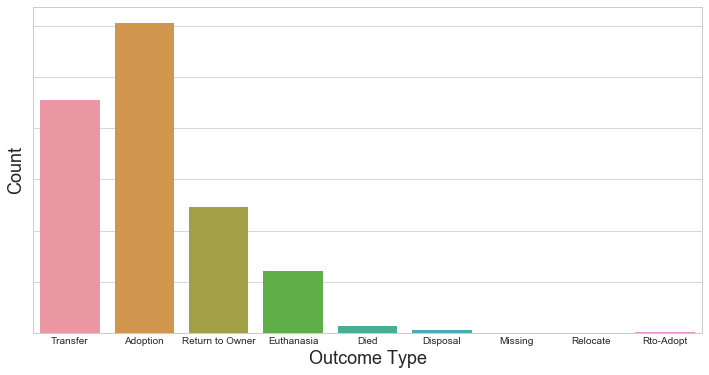

In [18]:
plt.figure(figsize=(12,6))

ax = sns.countplot(data['outcome_type'])
ax.set_xlabel('Outcome Type', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show;

Видим, что распределение классов целевой переменной сильно несбалансированное.

### Распределение временных признаков

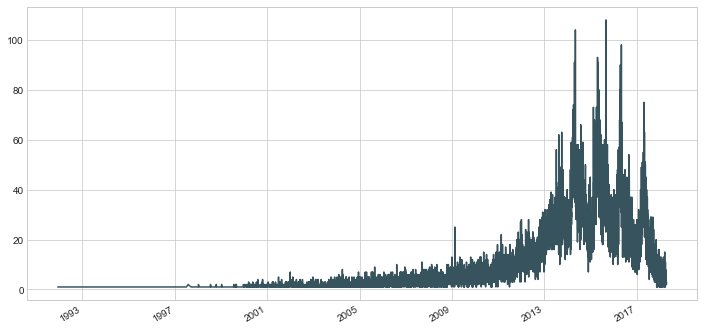

In [19]:
plt.figure(figsize=(12,6))
data['date_of_birth'].value_counts().sort_values().plot.line();

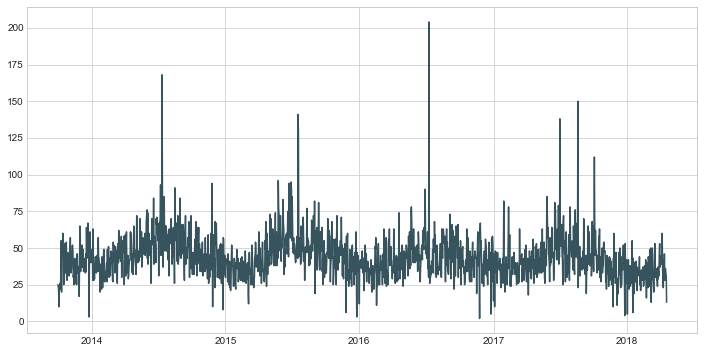

In [20]:
plt.figure(figsize=(12,6))
data['outcome_date'].value_counts().resample('D').sum().plot.line();

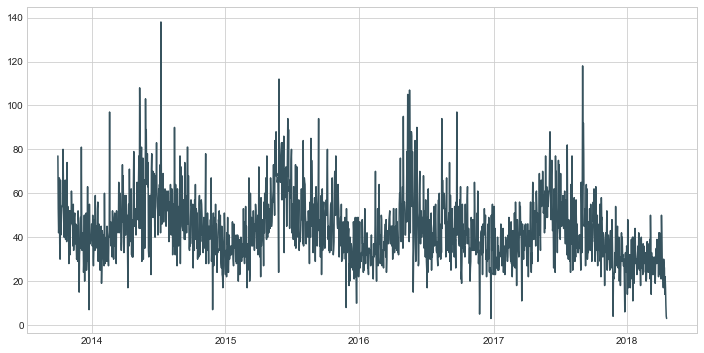

In [21]:
plt.figure(figsize=(12,6))
data['intake_date'].value_counts().resample('D').sum().plot.line();

Ясно видны годовые пики активности в деятельности центра.

### Анализ категориальных признаков

Сначала посмотрим на распределения бинарных и категориальных признаков (с числом категорий < 10) и целевой переменной:

In [27]:
def plot_cat(feature, loc='best', yscale='linear'):
    
    plt.figure(figsize=(12,6))    
    plt.xlabel(feature, fontsize=12)
    ax = sns.countplot(data[feature], hue=data['outcome_type']) 
    ax.set(yscale=yscale)
    ax.legend(loc=loc)

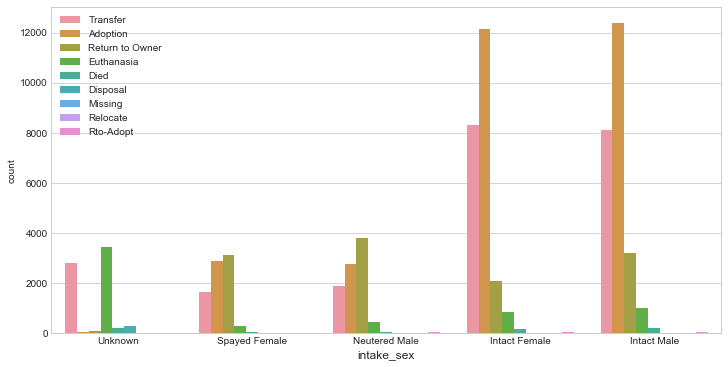

In [29]:
plot_cat('intake_sex')

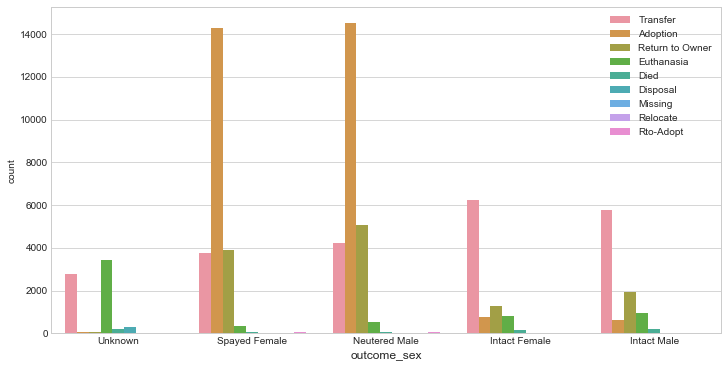

In [30]:
plot_cat('outcome_sex')

Из этих двух предыдущих графиков видно, что большую часть поступающих животных стерилизуют (Это обычная практика в приютах/центрах для животных).

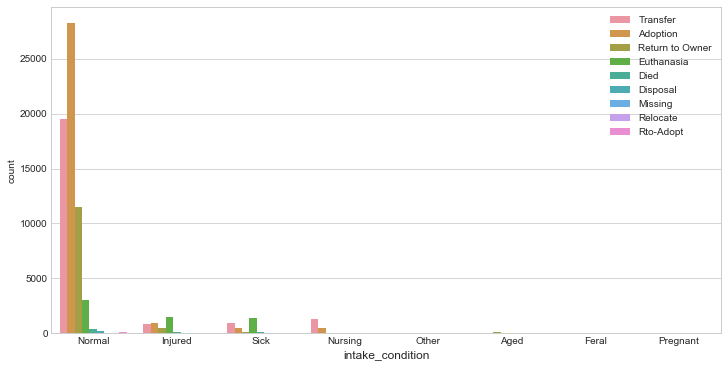

In [32]:
plot_cat('intake_condition', loc=1)

Видно, что больные и раненные животные чаще подвергаются эвтаназии, чем найденные в здоровом состоянии.

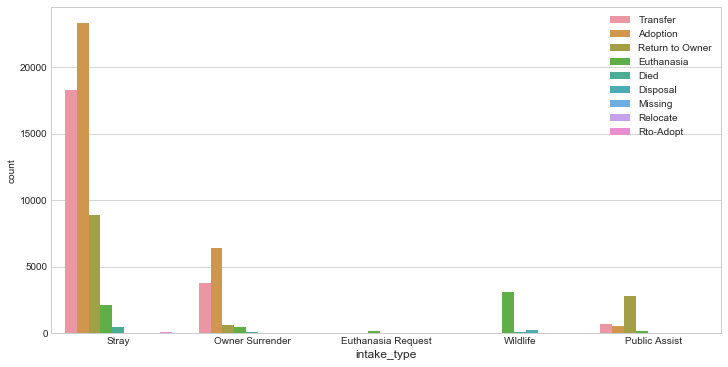

In [33]:
plot_cat('intake_type')

К сожалению, почти всех поступивших диких животных усыпляют.

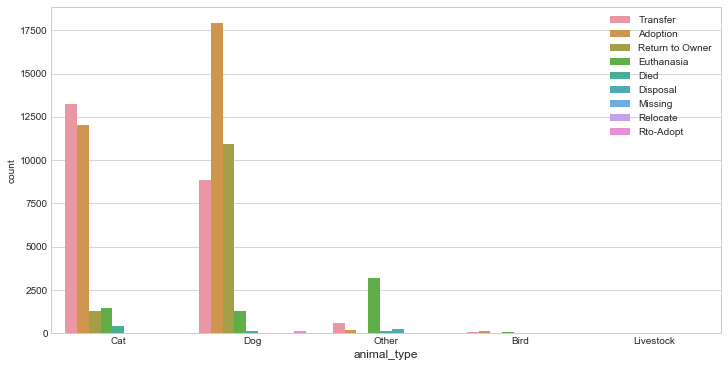

In [35]:
plot_cat('animal_type', loc=1)

Интересное наблюдение: кошек гораздо реже, чем собак, возвращают владельцам.

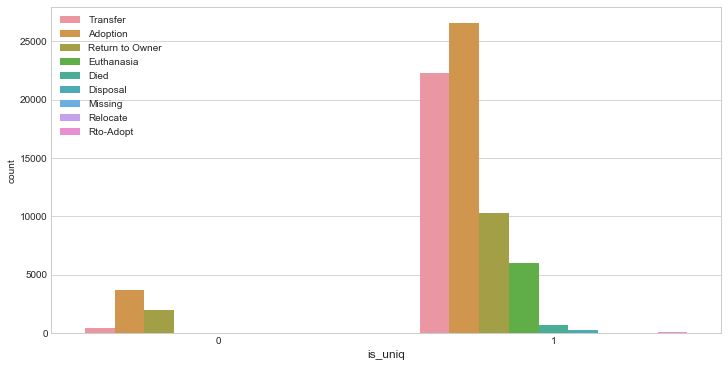

In [36]:
plot_cat('is_uniq', loc=2)

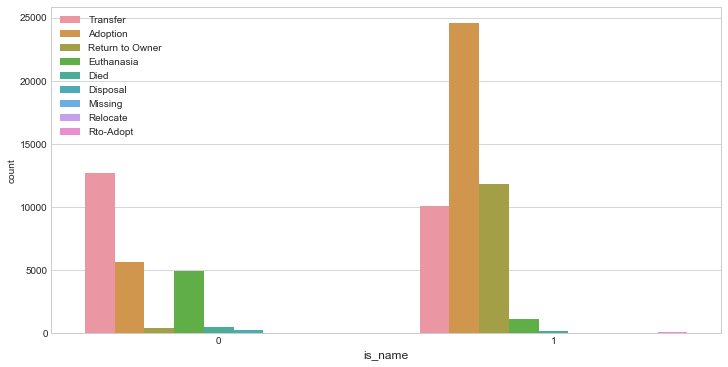

In [38]:
plot_cat('is_name')

Животных с именами гораздо чаще возвращают владельцу (интерпретируемо, так как если известно имя, то скорее всего на кошке или собаке есть медальон с именем и адресом хозяина, или просто известно чье это животное). Что интереснее - животных с именами чаще и пристраивают новым владельцам. (Вешайте медальоны с адресом на кошек и собак!)

Теперь посмотрим на распределения топ-10 пород, цвета и места где нашли, в зависимости от целевой переменной:

In [41]:
outcome_types = list(set(data['outcome_type'].values))

def find_top10(feature):
    
    out_dict={}    
    for i in outcome_types:
        out_dict[i] = list(data[data['outcome_type'] == i][feature].value_counts().head(10).keys())
        
    return out_dict


def plot_top10(feature):
    
    for idx, outcome in enumerate(outcome_types):
        top_feature_list = find_top10(feature)[outcome]
        data_x = data[data[feature].apply(lambda x: x in top_feature_list)][data['outcome_type']==outcome][feature]
        order=data_x.value_counts().index
        
        plt.figure(figsize=(16,4))
        plt.xticks(rotation=75, fontsize=12)
        ax = 'ax{}'.format(idx)
        ax = sns.countplot(data_x, order=order)
        ax.set_title(outcome, fontsize=12)
        ax.set_xlabel(xlabel='')
        #ax.tick_params(rotation=75, labelsize=12)

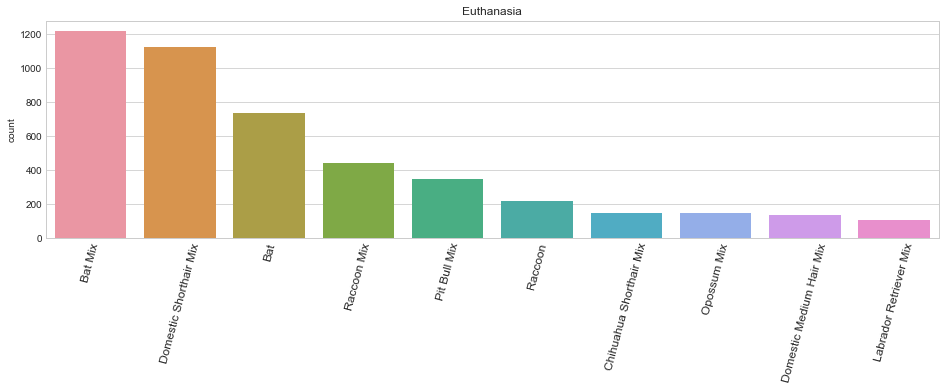

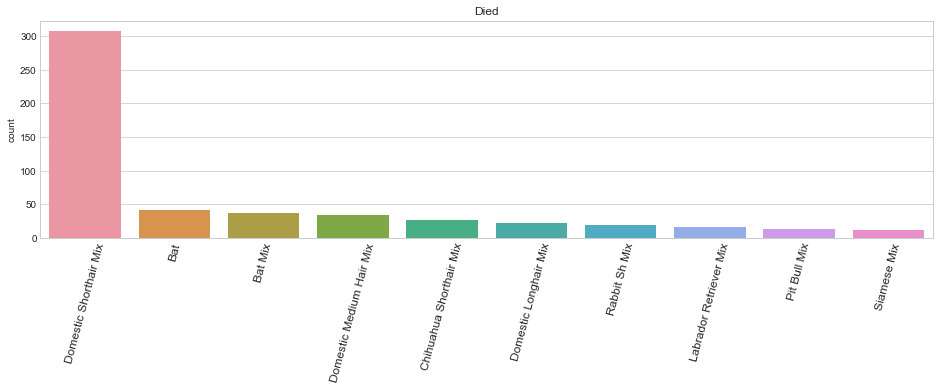

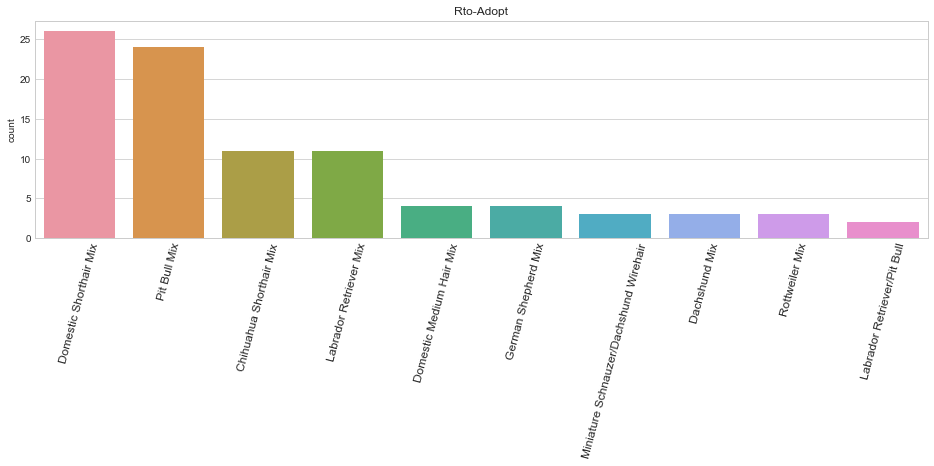

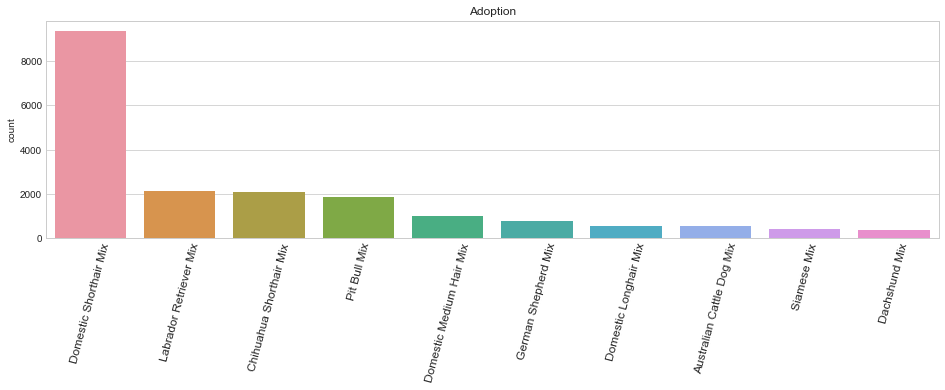

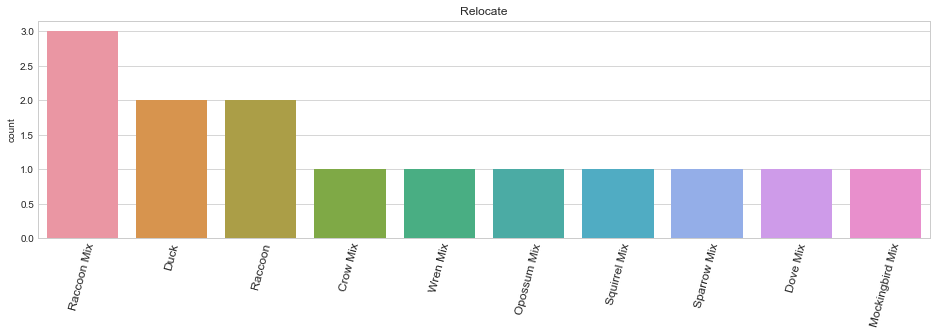

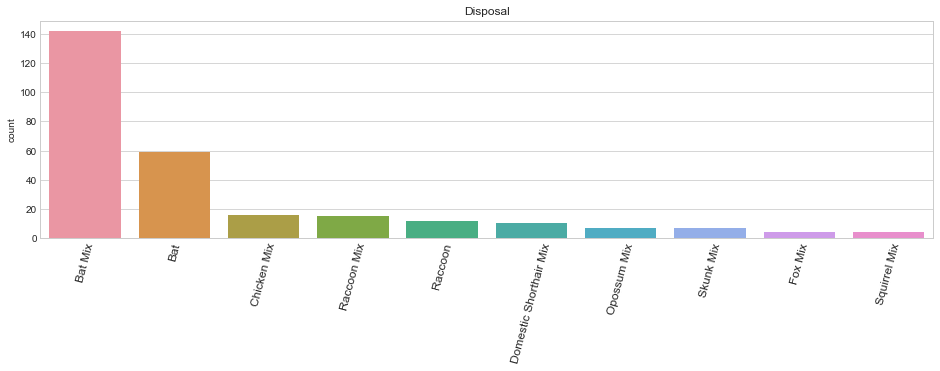

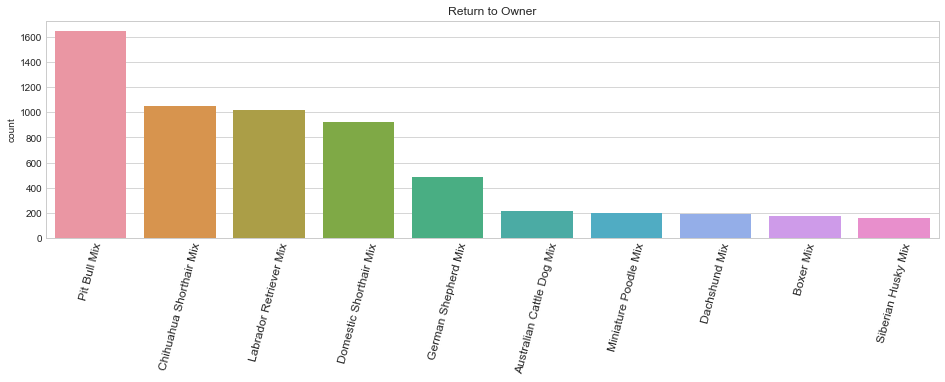

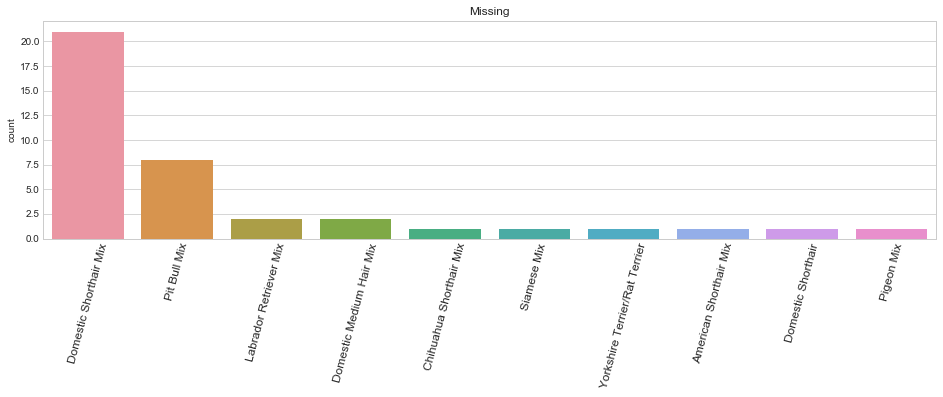

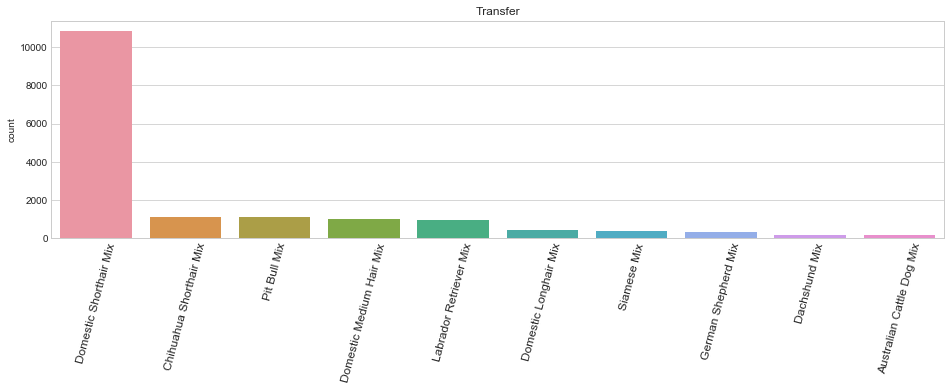

In [42]:
plot_top10('breed')

В топе возвращаемых владельцу - породы собак, диких животных в основном выпускают или подвергают эвтаназии (видимо, пораненных), неоижданно в топе пристраиваемых и умерших порода кошки "обычная домашняя".

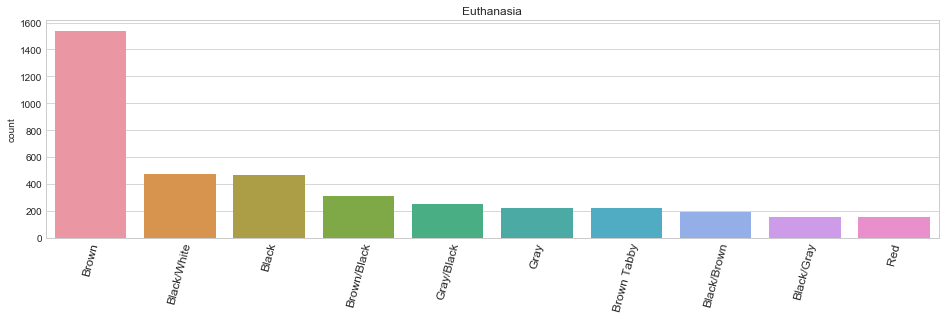

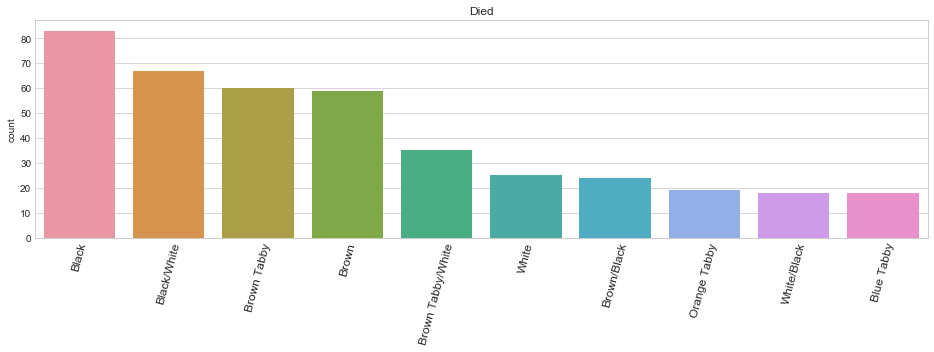

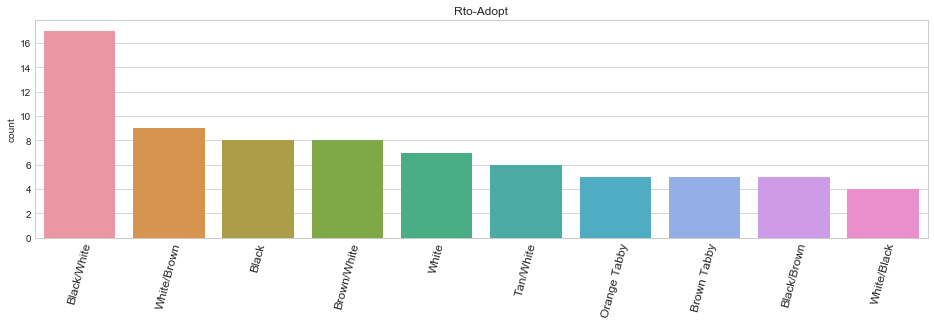

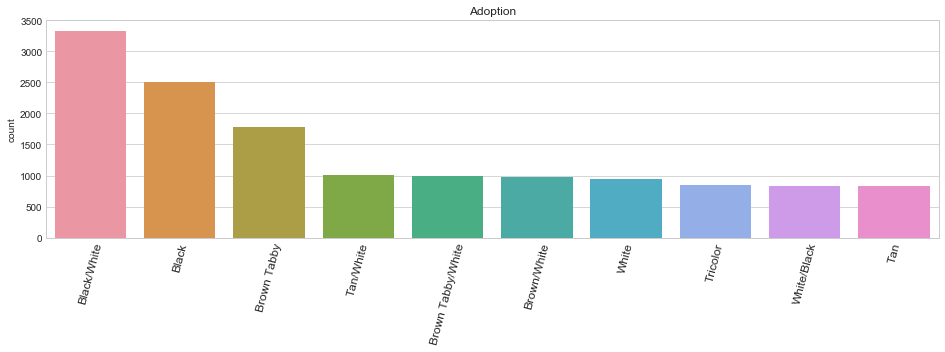

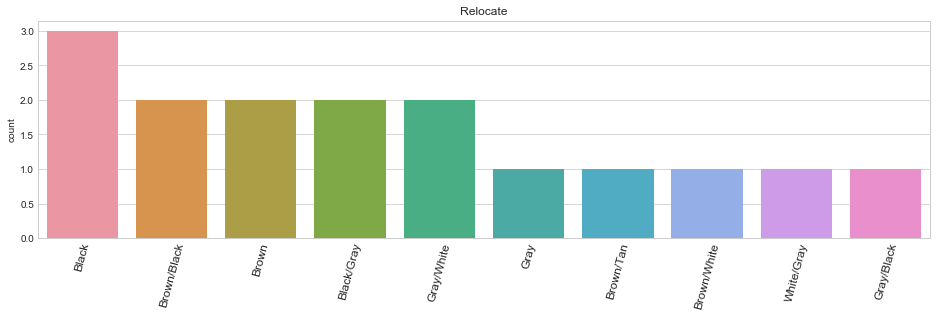

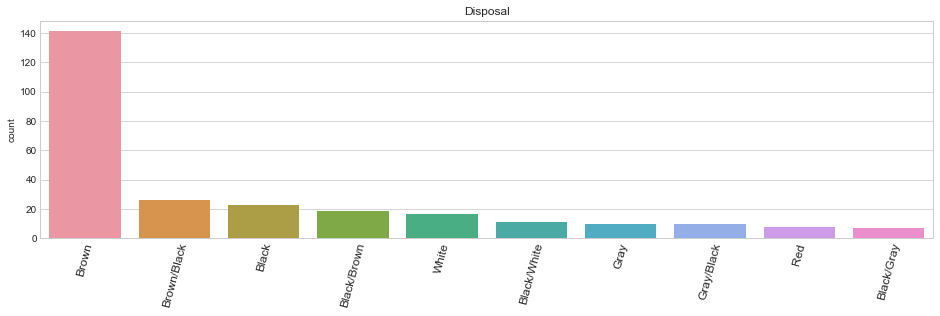

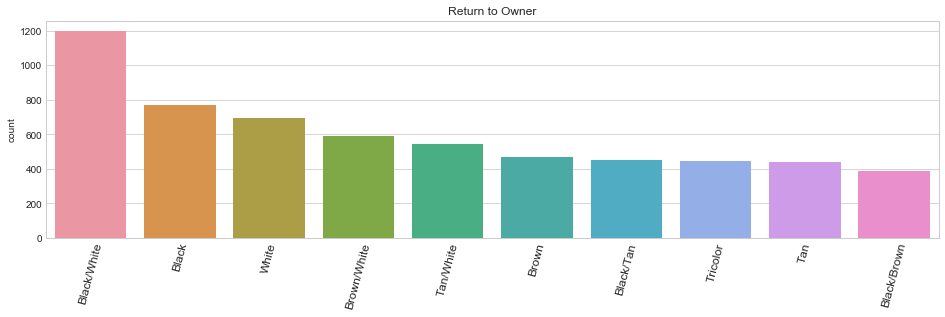

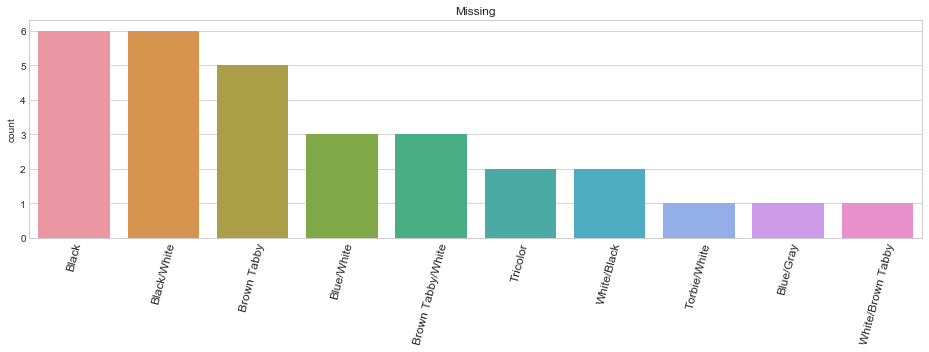

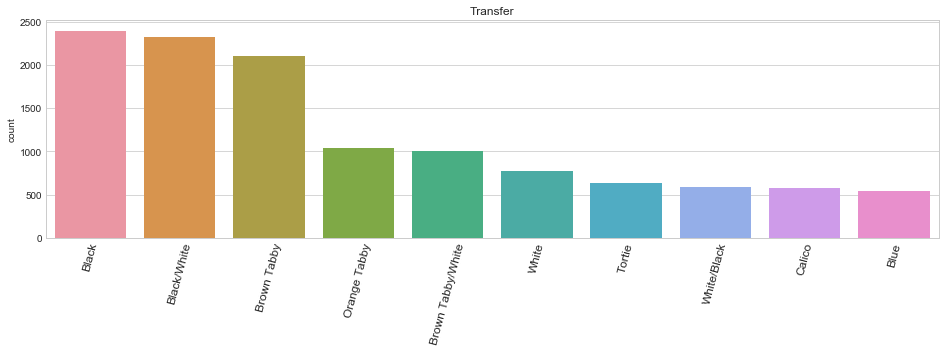

In [43]:
plot_top10('color')

Каких-то особо интересных закономерностей нет, кроме того, что везде преобладают окрасы черный, черно-белый и коричневый.

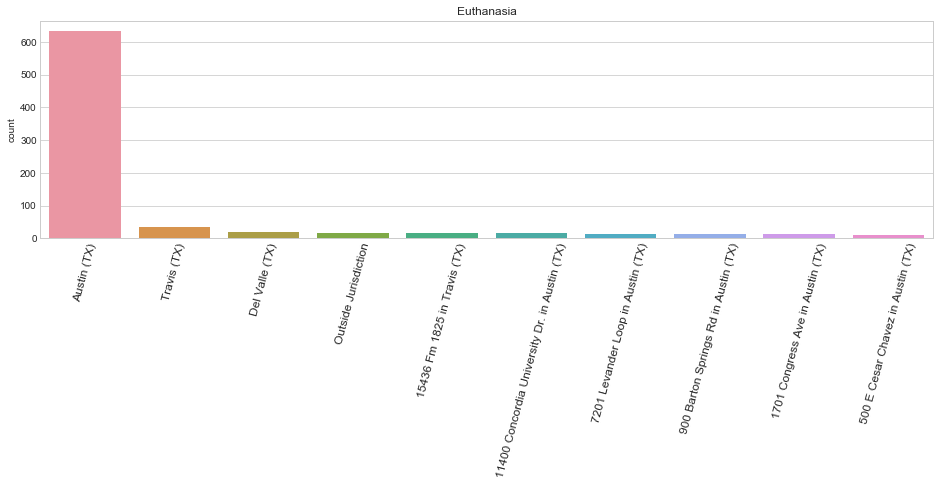

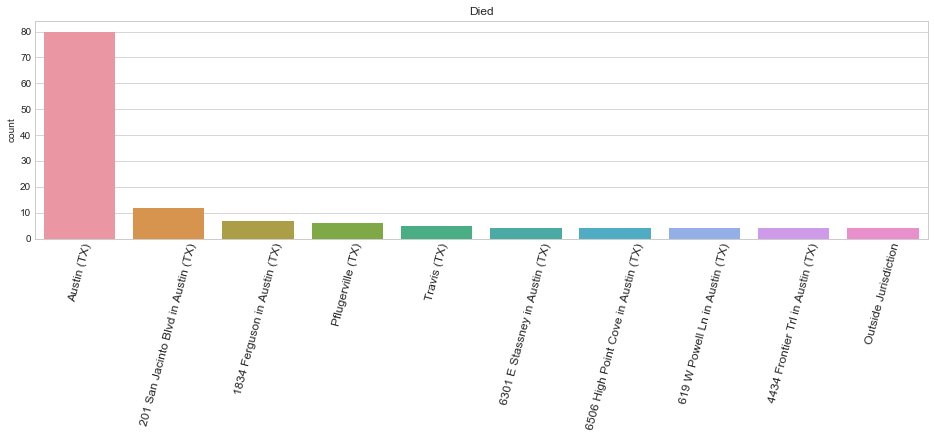

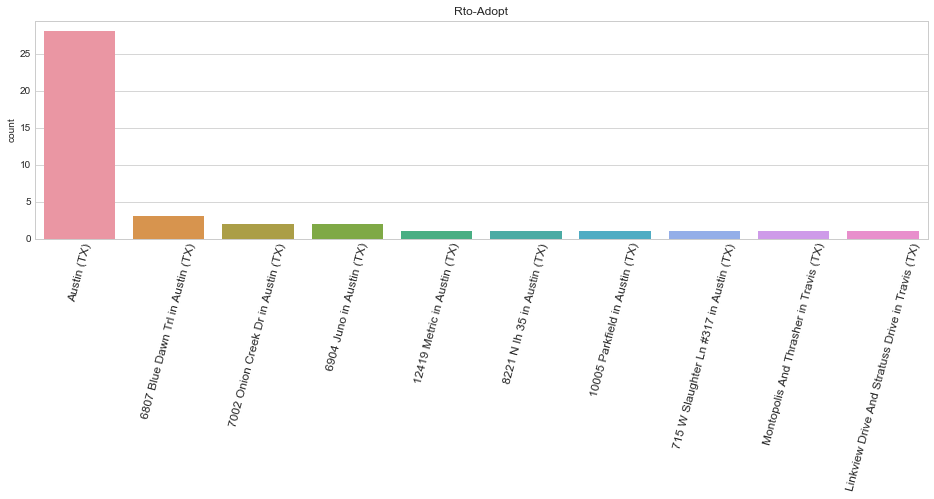

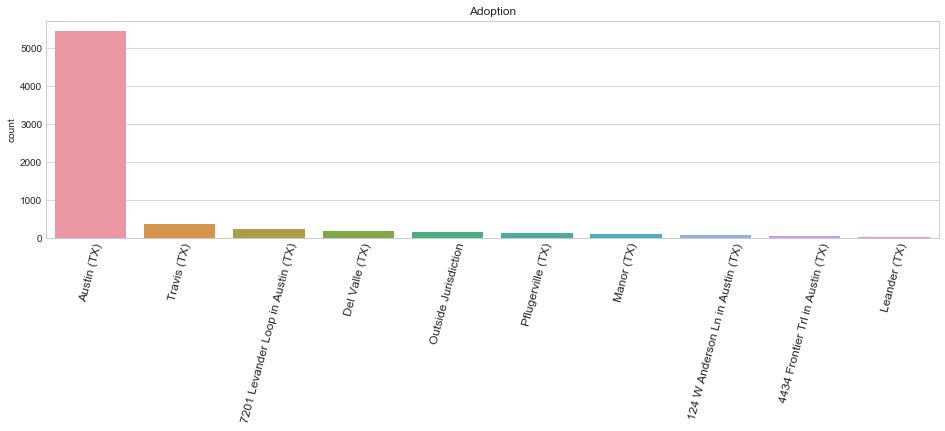

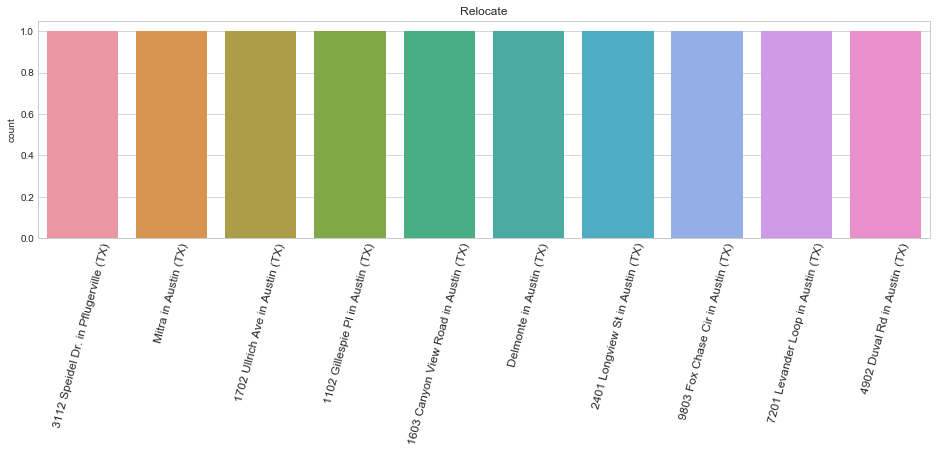

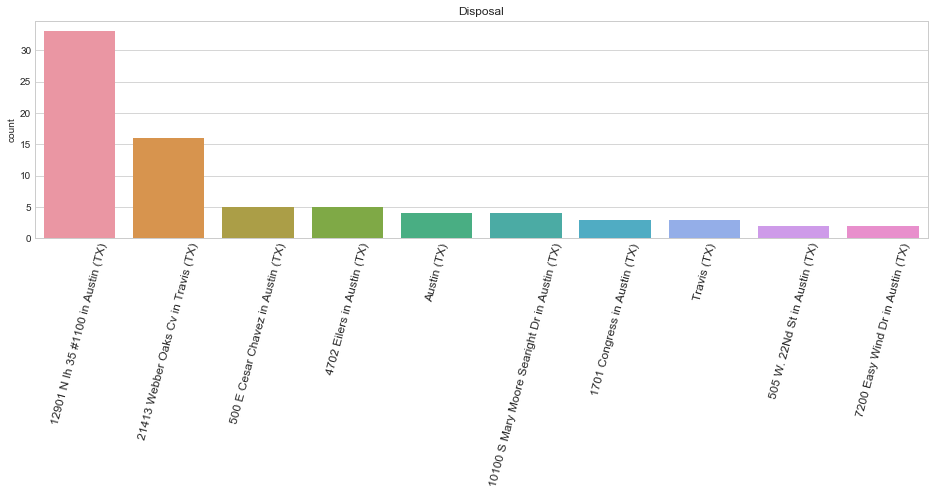

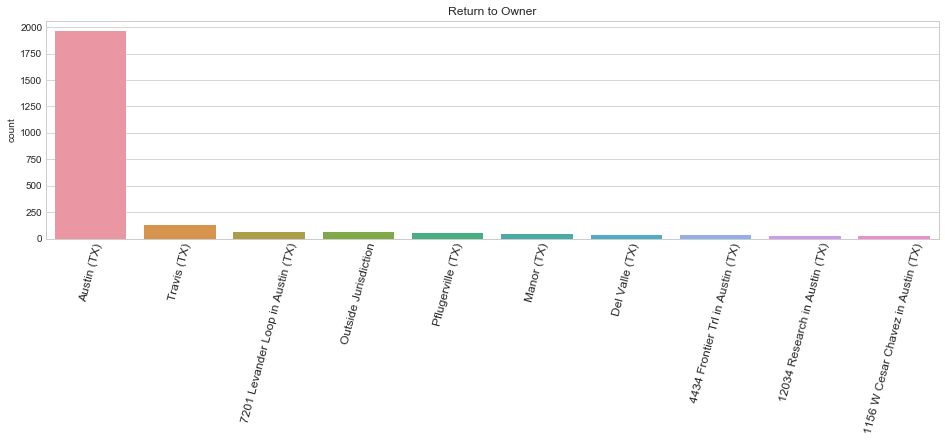

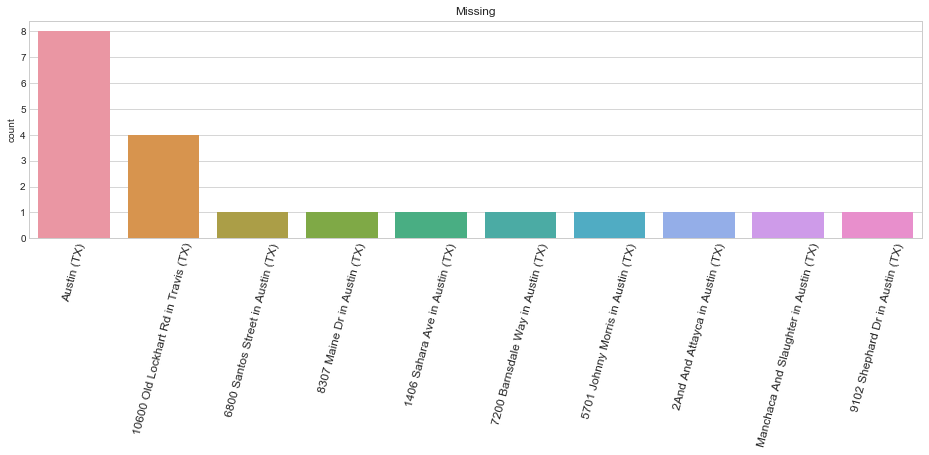

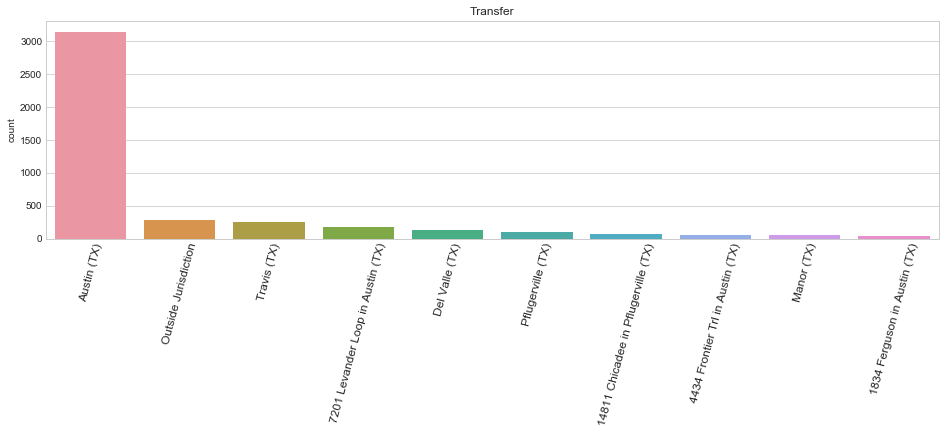

In [44]:
plot_top10('found_location')

Тоже особо интересного ничего нет, кроме того, что почти всех домашних животных находят в городе Austin.

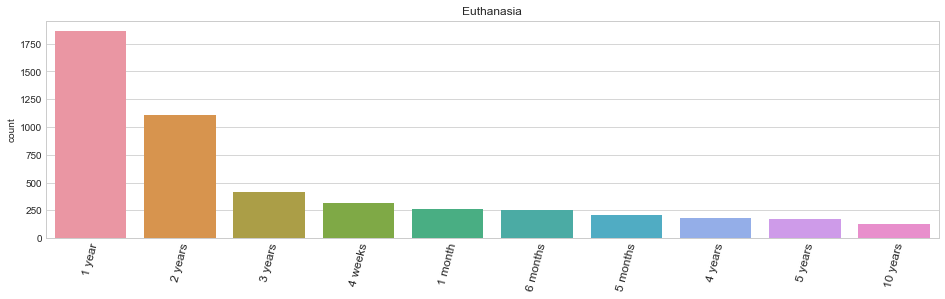

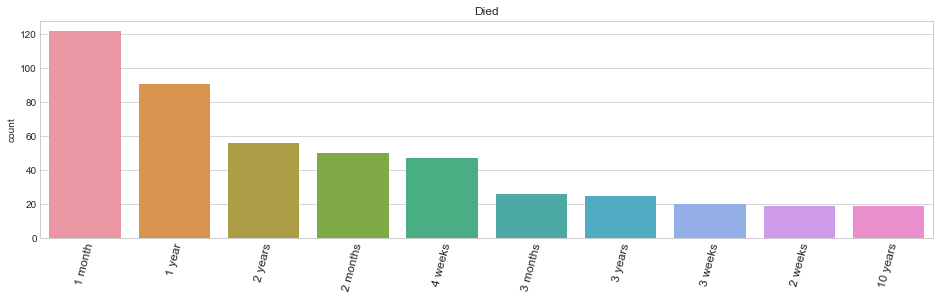

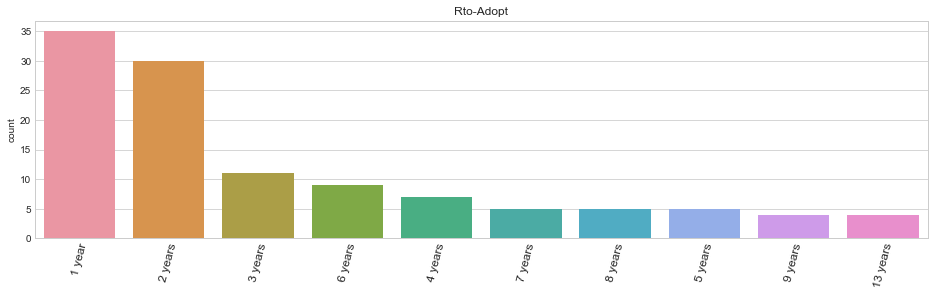

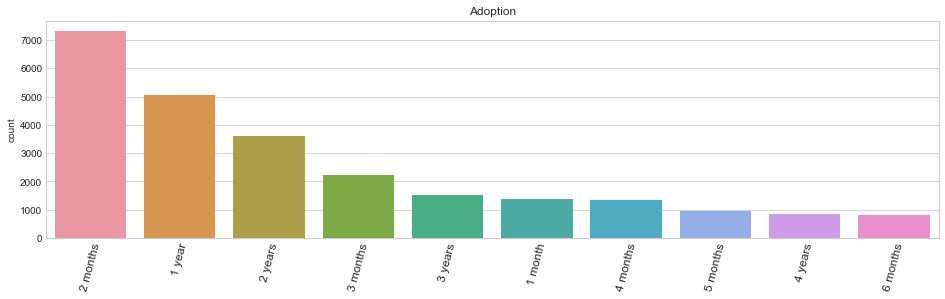

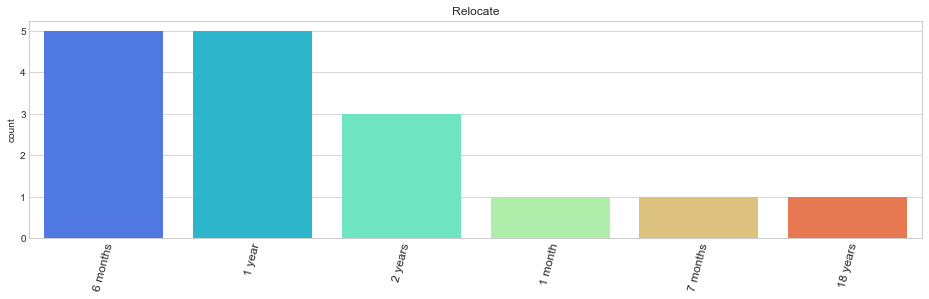

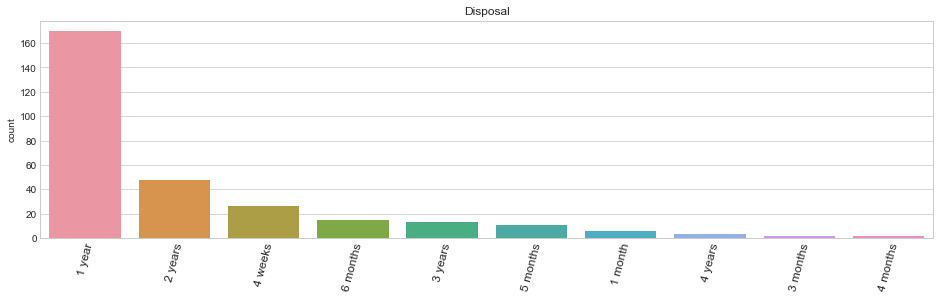

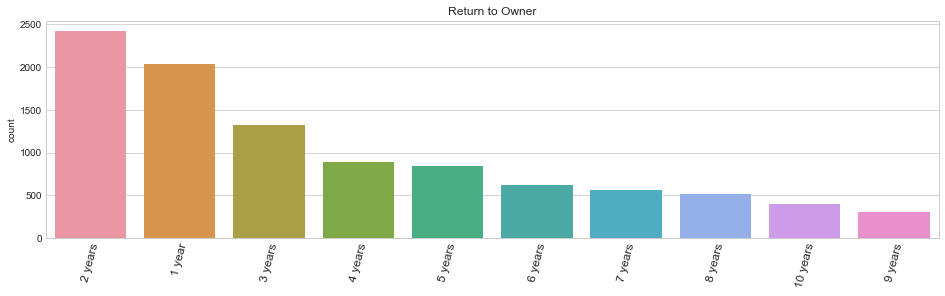

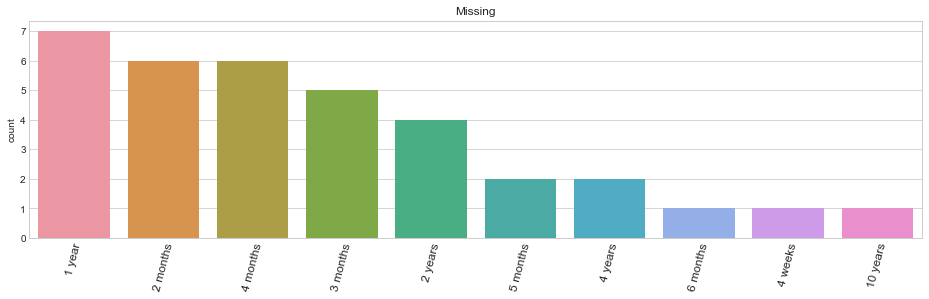

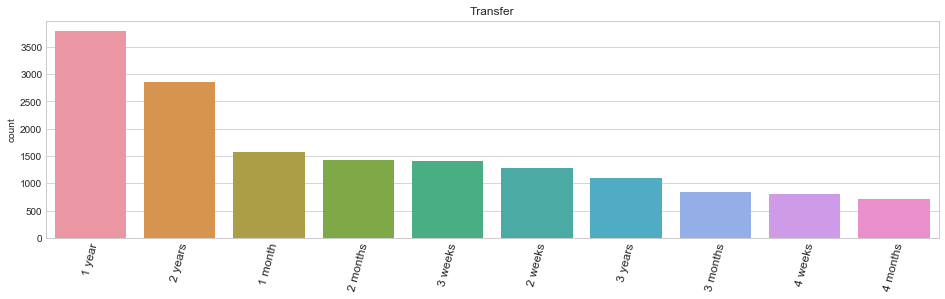

In [45]:
plot_top10('outcome_age')

Интересные закономерности, пристраивают в основном щенков и котят, возвращают взрослых животных.

##  Закономерности, "инсайты", особенности данных

Особенностью данных являются разнородные признаки с преобладанием категориальных, причем с большим количеством значений. Наблюдаются некоторые зависимости между признаками и целевой переменной, например, животных с именами забирают больше, найденных диких больше подвергают эвтаназии, и так далее. Однако, то, что кастрированные и стерилизованные животные составляют большинство при пристройстве, означает лишь что, что большинство животных попавших в приют, как известно, стерилизуют, так что не все зависимости полезны.

## Выбор метрики

У нас задача многоклассовой классификации, причем с несбалансированными классами. Accuracy (просто доля верных ответов) сразу отпадает, так как нам будут важны результаты классификации по различным классам. Это удобно смотреть по таблице <b>classification report</b>, которая выводит результаты <b>presicion</b> (точность, насколько точно класс отделяется от других), <b>recall</b> (полнота, насколько хорошо, т.е "полно" мы находим этот класс) и <b>f1 меру</b> (среднее гармоническое между точностью и полнотой) по всем классам. Вот f1 меру и будем использовать (с микроусреднением по классам из-за несбалансированности целевой переменной) для измерения результатов моделей, периодически сверяясь с classification report.

## Выбор модели

Особенностью данных является разные категориальные признаки, соотвественно нам подойдут модели, которые умеют работать с категориальными признаками, и возможно, с большим количеством значений. Я думаю, нам подойдет случайный лес, возможно, линейные модели и градиентный бустинг. Выберем случайный лес за его простоту, качество и интерпретируемость.

## Предобработка данных

Первым делом, преобразуем данные о возрасте.

Ясно видно, что возраст животных в 'outcome_age' и 'intake_age' дан приблизительно, да и к тому же в разных единицах измерения (2 weeks, 1 year и так далее), и является на данный момент категориальными и неуопрядоченным. (Модель не будет "знать" что месяц меньше года и т.д). Для более точного анализа будет лучше вычислить возраст напрямую (на момент пристройства животного), используя данные в столбце 'date_of_birth'.

In [47]:
data['outcome_age'] = round((data['outcome_date'] - data['date_of_birth'])/np.timedelta64(1,'W'),2)
data['intake_age'] = round((data['intake_date'] - data['date_of_birth'])/np.timedelta64(1,'W'),2)

Посмотрим, что получилось:

In [48]:
data['outcome_age'].describe()

count    72577.000000
mean       112.267846
std        153.905921
min        -17.490000
25%         12.540000
50%         52.760000
75%        127.360000
max       1305.290000
Name: outcome_age, dtype: float64

In [49]:
data['intake_age'].describe()

count    72577.000000
mean       110.008795
std        153.709138
min        -15.500000
25%          9.520000
50%         52.230000
75%        117.520000
max       1304.660000
Name: intake_age, dtype: float64

Есть записи с отрицательным возрастом, видимо, в записях о дне рождения были ошибки, заменим такие записи нулем:

In [50]:
data[data['outcome_age']<0]['outcome_age'] = 0
data[data['intake_age']<0]['intake_age'] = 0

#### Выделим и преобразуем целевой признак

In [51]:
target = data['outcome_type']

map_dir = {'Adoption':0, 'Died':1, 'Disposal':2, 'Euthanasia':3, 'Missing': 4, \
           'Relocate':5,'Return to Owner':6, 'Rto-Adopt':7, 'Transfer':8}

map_rev = {0:'Adoption', 1:'Died', 2:'Disposal', 3:'Euthanasia', 4:'Missing', \
           5:'Relocate', 6:'Return to Owner', 7:'Rto-Adopt', 8:'Transfer'}

y_ = target.map(map_dir)
y = y_.values

In [52]:
y_.value_counts()

0    30285
8    22748
6    12299
3     6061
1      679
2      306
7      141
4       42
5       16
Name: outcome_type, dtype: int64

Категориальные признаки преобразуем с помощью LabelEncoder, так как лес не любит слишком много признаков (а их получится много если будем использовать технику One Hot Encoder).

In [53]:
def lab_encoder(df, columns):    
    for col in columns:
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])
    return df

In [54]:
data_cat = data[cat_features].copy()
data_le = lab_encoder(data_cat, cat_features)

Соединим преобразованные признаки с бинарными и с возрастом в неделях.

In [55]:
data_rf = pd.concat([data_le, data[age_features], data[bin_features], data[month_features]], axis=1)

Разделим выборки на обучающую и отложенную, так как классы не сбалансированы, будем использовать параметр stratify:

In [56]:
X_train_rf, X_holdout_rf, y_train_rf, y_holdout_rf = train_test_split(data_rf, y, test_size=0.3,
                                                    random_state=17, stratify=y)

## Обучение, кросс-валидация, подбор параметров

В параметрах случайного леса укажем class_weight='balanced'. Для оценивания качества модели будем использовать f1_score, для этого создадим scorer из metrics.f1_score, укажем микроусреднение по классам. При разбиенни по фолдам в кроссвалидации будем учитывать дисбаланс классов с помощью StratifiedKFold.

In [57]:
rf = RandomForestClassifier(class_weight='balanced')

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
f1_scorer = make_scorer(f1_score, average='micro')
rf_params={'n_estimators':[100, 150, 300], 'min_samples_leaf':[2,3,5]}

grid_rf = GridSearchCV(rf, rf_params, n_jobs=-1, cv=skf, verbose=1, scoring=f1_scorer)

In [58]:
%%time
grid_rf.fit(X_train_rf, y_train_rf)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:  2.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': [100, 150, 300], 'min_samples_leaf': [2, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=micro), verbose=1)

In [59]:
print ('Best score: ' , grid_rf.best_score_)
print ('Best params: ' , grid_rf.best_params_)
print ('Test std mean: ' , np.array(grid_rf.cv_results_['std_test_score']).mean())

Best score:  0.7879849615180206
Best params:  {'min_samples_leaf': 2, 'n_estimators': 300}
Test std mean:  0.004439760790696787


Посмотрим на важность признаков с точки зрения леса:

In [61]:
feat_importance = pd.DataFrame(X_train_rf.columns, columns = ['features'])
feat_importance['value'] = grid_rf.best_estimator_.feature_importances_
feat_importance.sort_values('value')[::-1]

,features,value
9,outcome_age,0.115349
10,intake_age,0.109807
13,outcome_monthyear,0.097892
14,intake_monthyear,0.092424
7,found_location,0.080491
0,name,0.077170
2,breed,0.072700
4,outcome_sex,0.070613
3,animal_type,0.061494
1,color,0.058625


## Создание новых признаков и описание этого процесса

<b>Признак  "время пребывания  в приюте"</b>

Выше мы видели, что временные признаки intake_month и outcome_month важны, попробуем скомбинировать их создав новый признак.

In [62]:
data['time_in'] = round((data['outcome_date'] - data['intake_date'])/np.timedelta64(1,'D'),2)

Проверим (вдруг опять ошибки в данных):

In [63]:
data['time_in'].describe()

count    72577.000000
mean        15.813336
std         41.858475
min      -1506.950000
25%          1.080000
50%          4.970000
75%         13.230000
max       1101.780000
Name: time_in, dtype: float64

Заменим кривые значения нулями:

In [64]:
data[data['time_in']<0]['time_in'] = 0

<b>Признак цвет + порода</b>

Предположение: так как цвет и порода неплохо оцениваются моделью, сделаем на основе этих двух признаков новый.

In [65]:
data['color_breed'] = data['color'] + ' ' + data['breed']

<b>Признак "есть mix в названии породы", признак "помесь двух пород"</b>

Интуитивное предположение: может быть, для пристройства важна чистопородность кошки или собаки. Эту информацию можно извлечь из колонки 'breed': Mix - не чистопородное животное, запись двух пород через слэш - помесь этих двух пород.

In [66]:
data['is_mix'] = data['breed'].apply(lambda x: 1 if 'mix' in x.lower() else 0)

In [67]:
data['crossbreed'] = data['breed'].apply(lambda x: 1 if '/' in x else 0)

Поссмотрим, что получилось:

In [68]:
data.sample(5)

,animal_id,name,outcome_date,outcome_monthyear,date_of_birth,outcome_type,animal_type,outcome_sex,outcome_age,breed,...,intake_type,found_location,intake_sex,intake_monthyear,intake_date,intake_age,time_in,color_breed,is_mix,crossbreed
38312,A719052,Onyx,2016-01-12 00:00:00,201601,2015-11-02,Transfer,Dog,Intact Female,10.14,Pit Bull/Chihuahua Shorthair,...,Owner Surrender,Austin (TX),Intact Female,201601,2016-01-11 16:53:00,10.10,0.30,Black/White Pit Bull/Chihuahua Shorthair,0,1
49920,A733853,*Scuttlee,2016-10-03 09:20:00,201610,2013-08-28,Transfer,Dog,Intact Female,161.77,Dachshund Mix,...,Stray,Manor (TX),Intact Female,201608,2016-08-28 11:10:00,156.64,35.92,Red Dachshund Mix,1,0
47826,A733230,Unknown,2016-08-20 09:00:00,201608,2016-05-04,Transfer,Cat,Intact Female,15.48,Domestic Shorthair Mix,...,Stray,2210 W 35Th St in Austin (TX),Intact Female,201608,2016-08-19 11:01:00,15.35,0.92,Brown Tabby Domestic Shorthair Mix,1,0
69741,A761723,Unknown,2018-01-24 08:10:00,201801,2017-10-24,Adoption,Cat,Spayed Female,13.19,American Shorthair Mix,...,Stray,Manchaca Rd And East William Cannon in Austin ...,Intact Female,201711,2017-11-08 11:58:00,2.21,76.84,Brown Tabby American Shorthair Mix,1,0
41368,A723567,Coco,2016-04-03 14:33:00,201604,2013-04-03,Return to Owner,Dog,Spayed Female,156.66,Yorkshire Terrier Mix,...,Stray,3816 Bronco Bend Lp in Austin (TX),Spayed Female,201604,2016-04-03 12:49:00,156.65,0.07,Silver Yorkshire Terrier Mix,1,0


### Обучим модель с новыми данными

In [69]:
columns = cat_features + ['color_breed']
data_le_new = lab_encoder(data, columns)

In [70]:
data_rf_new = pd.concat([data_le_new[columns], data['crossbreed'], data['is_mix'], data['time_in'], \
                         data['outcome_monthyear'], data['outcome_age'], data[bin_features]], axis=1)

In [71]:
X_train, X_holdout, y_train, y_holdout = train_test_split(data_rf_new, y, test_size=0.3,
                                                    random_state=17, stratify=y)

In [72]:
rf = RandomForestClassifier(class_weight='balanced')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
f1_scorer = make_scorer(f1_score, average='micro')
rf_params={'n_estimators':[100, 150, 300], 'min_samples_leaf':[2,3,5]}

grid_rf = GridSearchCV(rf, rf_params, n_jobs=-1, cv=skf, verbose=1, scoring=f1_scorer)

In [73]:
%%time
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  5.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': [100, 150, 300], 'min_samples_leaf': [2, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=micro), verbose=1)

In [74]:
print ('Best score: ' , grid_rf.best_score_)
print ('Best params: ' , grid_rf.best_params_)
print ('Test std mean: ' , np.array(grid_rf.cv_results_['std_test_score']).mean())

Best score:  0.8225498494183414
Best params:  {'min_samples_leaf': 2, 'n_estimators': 300}
Test std mean:  0.0038184714558879484


In [75]:
feat_importance = pd.DataFrame(X_train.columns, columns = ['features'])
feat_importance['value'] = grid_rf.best_estimator_.feature_importances_
feat_importance.sort_values('value')[::-1]

,features,value
12,time_in,0.154292
15,outcome_age,0.085293
16,intake_age,0.080627
13,outcome_monthyear,0.080610
14,intake_monthyear,0.072418
4,outcome_sex,0.067693
0,name,0.059873
7,found_location,0.059146
3,animal_type,0.056296
2,breed,0.055295


Как мы видим, качество модели на кросс-валидации подросло! С новым признаком "время, проведенное в приюте", мы также угадали. Также сочетание 'цвет + порода' неплох (можно было бы попробовать использовать на этом признаке TfIdf). А вот дворняги это, помеси или чистопородные, не очень важно.

## Построение кривых валидации и обучения 

In [76]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

<b>Построим кривые валидации</b>, будем менять сложность модели изменяя параметры.

In [77]:
f1_scorer = make_scorer(f1_score, average='micro')
rf_val = RandomForestClassifier(class_weight='balanced', random_state=17)

Посмотрим на зависимость от числа деревьев.

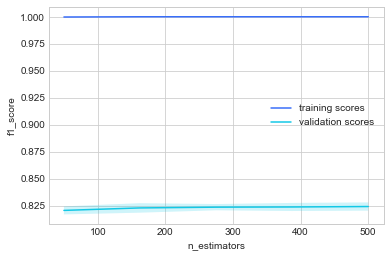

In [78]:
n = np.linspace(50, 500, 5).astype(int)

val_train, val_test = validation_curve(rf_val, X_train, y_train,
                                       'n_estimators', n, cv=skf,
                                       scoring=f1_scorer, n_jobs=-1)

plot_with_err(n, val_train, label='training scores')
plot_with_err(n, val_test, label='validation scores')
plt.xlabel('n_estimators'); plt.ylabel('f1_score')
plt.legend();

Посмотрим на зависимость от числа объектов в листе.

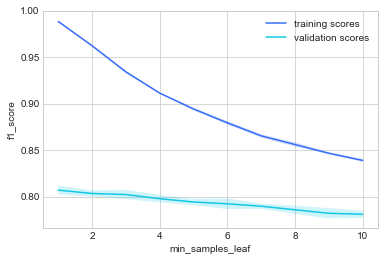

In [80]:
n = np.linspace(1, 10, 10).astype(int)

val_train, val_test = validation_curve(rf_val, X_train, y_train,
                                       'min_samples_leaf', n, cv=skf,
                                       scoring=f1_scorer, n_jobs=-1)

plot_with_err(n, val_train, label='training scores')
plot_with_err(n, val_test, label='validation scores')
plt.xlabel('min_samples_leaf'); plt.ylabel('f1_score')
plt.legend();

Усложнение модели не приводит к росту качества.

<b>Построим обучающие кривые.</b>

In [81]:
def plot_learning_curve(min_samples_leaf=2, n_estimators=300):
    train_sizes = np.linspace(0.05, 1, 20)
    
    rf_learn = RandomForestClassifier(class_weight='balanced', min_samples_leaf=min_samples_leaf, n_estimators = n_estimators)
    N_train, val_train, val_test = learning_curve(rf_learn, X_train, y_train, train_sizes=train_sizes, cv=skf,
                                                  scoring=f1_scorer, n_jobs=-1)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('f1 score')
    plt.legend()

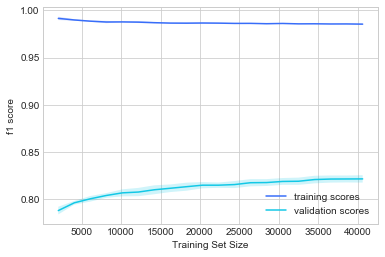

In [82]:
plot_learning_curve()

Видим рост на кросс-валидации при увеличении датасета, возможно новые данные помогут.

## Прогноз для тестовой или отложенной выборки

Сделаем оценку на отложенной выборке, используя лучшую модель из предыдущего шага.

In [84]:
best_rf = grid_rf.best_estimator_

In [85]:
y_predict = best_rf.predict(X_holdout)

In [86]:
report = classification_report(y_holdout, y_predict)
print(report, '\n', map_rev)

             precision    recall  f1-score   support

          0       0.80      0.94      0.86      9086
          1       0.53      0.10      0.17       204
          2       0.57      0.32      0.41        92
          3       0.85      0.75      0.80      1818
          4       1.00      0.08      0.15        12
          5       0.00      0.00      0.00         5
          6       0.88      0.83      0.85      3690
          7       0.00      0.00      0.00        42
          8       0.84      0.72      0.78      6825

avg / total       0.82      0.82      0.82     21774
 
 {0: 'Adoption', 1: 'Died', 2: 'Disposal', 3: 'Euthanasia', 4: 'Missing', 5: 'Relocate', 6: 'Return to Owner', 7: 'Rto-Adopt', 8: 'Transfer'}


Как мы видим, модель все-таки не очень хорошо различает малочисленные классы, но качество на отложенной выборке хорошее.

### Оценка модели с описанием выбранной метрики

Итак, мы видим, что хоть модель и старалась оптимизировать f1 score, малочисленные классы (потерявшиеся животные, выпущенные в другом месте и возвращенные владельцу взявшему на адаптацию) она различает очень плохо. Вообще, с точки зрения применения, нам важнее всего предсказать, найдутся ли у данного животного хозяева, или возьмут ли его в новую семью. Возможно, удастся улучшить результат, использую данные не только о породе, но и о размере, пушистости, характере, и так далее, часть этих данных тяжело, но возможно, извлекается из данных о породе.

### Выводы 

Данные для исследования не очень чистые, много пропусков, дубликатов и неверных значений. На основе вычищенных данных построена модель для многоклассовой классификации (пристройства, возврата, и т.д) животного из приюта. Конкретно пристройство и возврат владельцу она предсказывает неплохо, но хотелось бы улучшить качество на малочисленных классах, возможно использование более интересных признаков поможет.